<a href="https://colab.research.google.com/github/lowbee2019/Algorithm/blob/master/MyModel-v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [270]:
!pip install emnist

In [271]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import collections
import copy
import random
import emnist

# Server Initialization

In [272]:
class ParamServer(object):
  def __init__(self,init_model_path):
    self.init_model_path = init_model_path
    self.round = 0
    self.optimizer="adam"
    self.loss = "sparse_categorical_crossentropy"
    self.metrics =['accuracy']
    self.loss_acc=[]

  def PreTrain(self,model,data,labels,batch_size=32,epochs=5):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    _metrics = model.fit(data,labels,batch_size,epochs)
    return model
  
  def PreEval(self,model,test_data,test_labels):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    self.loss_acc.append(model.evaluate(test_data,test_labels))


## Mnist数据集的预处理

In [113]:
mnist = tf.keras.datasets.mnist
train,test = mnist.load_data()
x_train,y_train = train
x_test,y_test = test
x_train,x_test = x_train/255.0,x_test/255.0

In [ ]:
x_train.shape

(60000, 28, 28)

## 模型的定义

In [273]:
class FLModel(tf.keras.Model):
  def __init__(self,row,col,num_classes=62,*args,**kwargs):
    super(FLModel,self).__init__(*args,**kwargs)
    self.row = row
    self.col = col
    self.num_classes = num_classes
    self.flatten = tf.keras.layers.Flatten(input_shape=(row,col))
    self.dense_1 = tf.keras.layers.Dense(500,activation='relu',name="dense_1")
    self.dense_2 = tf.keras.layers.Dense(num_classes,activation='softmax',name="dense_2")
    self.drop = tf.keras.layers.Dropout(0.2)


  def call(self,inputs):
    x = self.flatten(inputs)
    x = self.dense_1(x)
    x = self.drop(x)
    x = self.dense_2(x)
    return x
  
  def copy(self):
    NewModel = FLModel(self.row,self.col,self.num_classes)
    _ = NewModel(np.expand_dims(tf.zeros([self.row,self.col]),0))
    ##Layers
    NewVars = NewModel.trainable_variables #此处为空列表，因为没有训练,这个地方参数传递是不是有问题
    OldVars = self.trainable_variables
    for n,o in zip(NewVars,OldVars):
      n.assign(o.numpy())
    return NewModel

  # def compute_output_shape(self,input_shape):
  #   shape = tf.TensorShape(input_shape).as_list()
  #   shape[-1] = self.num_classes
  #   return tf.TensorShape(shape)

#Client Initialization
模型训练和评估都要重写

In [274]:
class Client(object):
  def __init__(self,id,model=None,Train_dataset=None,Test_dataset=None):
    self.id = id
    self.model = model
    self.Train_dataset = Train_dataset
    self.Test_dataset = Test_dataset
    # from ParamServer
    self.ParamModel = None
    self.num_epochs = 5
    self.batch_size = 32
    self.shuffle_buffer = 100
    self.prefetch_buffer = 10
    ## 


  def ReceiveModel(self,ParamModel,num_epochs=1,batch_size=32,shuffle_buffer=100,prefetch_buffer=10):
    self.ParamModel = ParamModel
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.shuffle_buffer = shuffle_buffer
    self.prefetch_buffer = prefetch_buffer
  

  def preprocess(self,dataset):
    def batch_format_fn(element):
      return collections.OrderedDict(
            
            x = tf.reshape(element['pixels'],[-1,784]),
            y = tf.reshape(element['label'],[-1,1])
          )
    return dataset.repeat(self.num_epochs).shuffle(self.shuffle_buffer).batch(
        self.batch_size).map(batch_format_fn).prefetch(self.prefetch_buffer)

  def NodeTrain(self):
    model = self.ParamModel
    # pre_data = self.preprocess(self.Train_dataset)
    # print(type(pre_data))
    # model.fit(x=pre_data['x'],y=pre_data['y'],batch_size=self.batch_size,epochs=self.num_epochs)
    # x = np.array([i['pixels'].numpy() for i in self.Train_dataset])
    # y = np.array([i['label'].numpy() for i in self.Train_dataset])
    x,y = self.Train_dataset
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    _metrics = model.fit(x,y,batch_size=self.batch_size,epochs=self.num_epochs)
    self.model = model

  def NodeEval(self):
    x,y = self.Test_dataset
    self.model.evaluate(x,y)


# 阶段一：为Client分配数据（预处理工作）

#阶段一：服务器完成模型初始化

In [ ]:
# emnist_dataset = emnist.extract_training_samples('byclass')

In [195]:
emnist_dataset = emnist.extract_training_samples('letters')

In [196]:
emnist_dataset = (emnist_dataset[0]/255.0,emnist_dataset[1]+9)

In [197]:
set(emnist_dataset[1])

{10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35}

In [ ]:
def create_data_for_clients(BasicSet,Num,TuneSet=train,TargetRate=0.7):
  #Alpha: 需要掺入mnist的占比
  #Beta: Emnist中数字的占比
  # Beta = 34.0/73.0
  Beta = 0
  if TargetRate < Beta:
    Alpha = 0
  else:
    Alpha = (TargetRate-Beta)/(1-Beta)
  TuneNum = int(Alpha*Num)
  BasicNum = Num-TuneNum
  x_sequence = []
  y_sequence = []
  print(TuneNum,BasicNum)
  if TuneNum > 0:
    for i in range(TuneNum):
      index = random.randint(0,len(TuneSet[0])-1)
      x_sequence.append(TuneSet[0][index])
      y_sequence.append(TuneSet[1][index])
  if BasicNum > 0:
    for i in range(BasicNum):
      index = random.randint(0,len(BasicSet[0])-1)
      x_sequence.append(BasicSet[0][index])
      y_sequence.append(BasicSet[1][index])
  return (np.array(x_sequence),np.array(y_sequence))

In [ ]:
# def create_data_for_clients(BasicSet,Num):
#   x_sequence = []
#   y_sequence = []
#   for i in range(Num):
#     index = random.randint(0,Num-1)
#     x_sequence.append(BasicSet[0][index])
#     y_sequence.append(BasicSet[1][index])
#   return (np.array(x_sequence),np.array(y_sequence))

In [311]:
NUM_CLIENTS = 12
NUM_TRAIN_SAMPLE_CLIENT = 1280
NUM_TEST_SAMPLE_CLIENT = 256

In [312]:
clients=[]
for i in range(NUM_CLIENTS):
  clients.append(Client(i,
                        Train_dataset=create_data_for_clients(emnist_dataset,NUM_TRAIN_SAMPLE_CLIENT,TargetRate=random.random()),
                        Test_dataset=create_data_for_clients(emnist_dataset,NUM_TEST_SAMPLE_CLIENT))
  )

782 498
179 77
133 1147
179 77
714 566
179 77
1000 280
179 77
795 485
179 77
913 367
179 77
737 543
179 77
76 1204
179 77
118 1162
179 77
549 731
179 77
1002 278
179 77
280 1000
179 77


Show DataSet

In [ ]:
import matplotlib.pyplot as plt

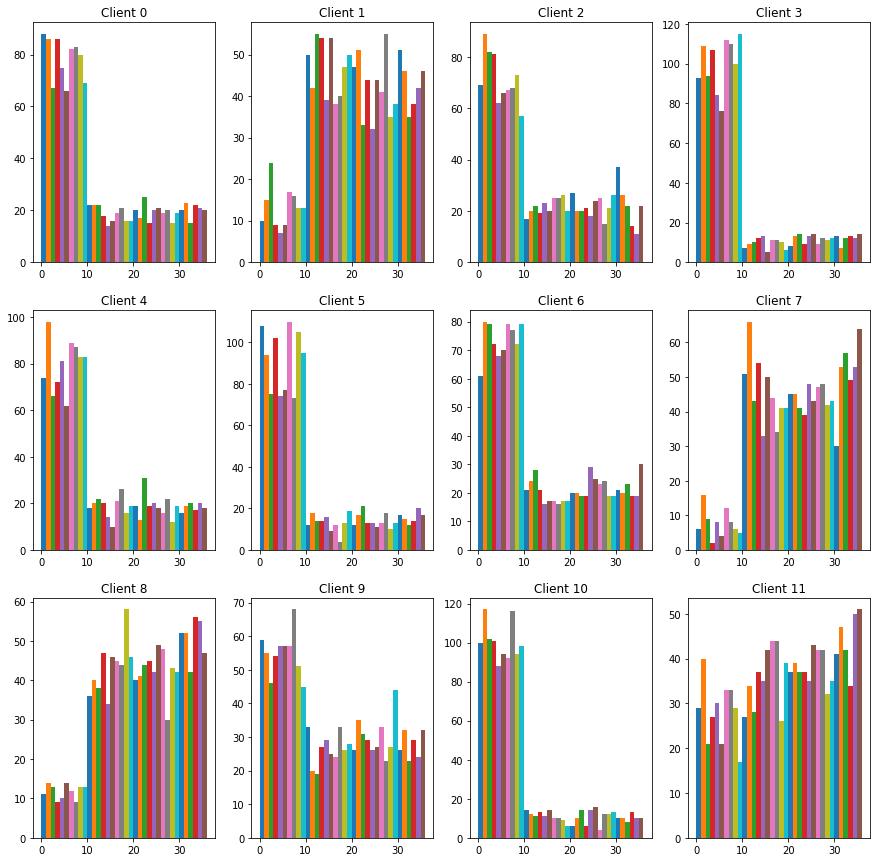

In [313]:
f = plt.figure(figsize=(15,15))
for i in range(NUM_CLIENTS):
  client_dataset = clients[i].Train_dataset
  plot_data = collections.defaultdict(list)
  for label in client_dataset[1]:
    plot_data[label].append(label)
  plt.subplot(3,4,i+1)
  plt.title('Client {}'.format(i))
  for j in range(len(plot_data)):
    plt.hist(
        plot_data[j],
        density = False,
        bins = [x for x in range(len(plot_data)+1)]
    )

显示一下数字与字母的对比


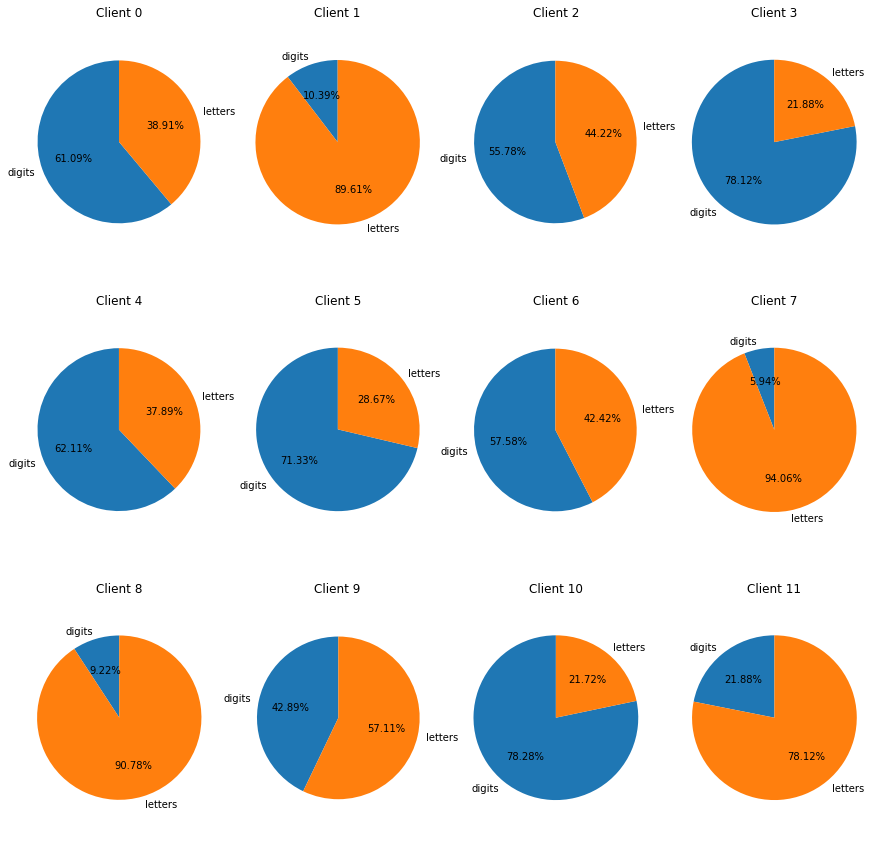

In [314]:
f = plt.figure(figsize=(15,15))
for i in range(NUM_CLIENTS):
  client_dataset = clients[i].Train_dataset
  plot_data = {0:0,1:0}
  plot_labels = ['digits','letters']
  for label in client_dataset[1]:
    label = 0 if label < 10 else 1
    plot_data[label]+=1
  # print(plot_data)
  data_labels = list(sorted(plot_data.keys()))
  # print(data_labels)
  data_nums = [plot_data[i] for i in data_labels]
  colors = ['red','blue']
  plt.subplot(3,4,i+1)
  patches,text1,text2 = plt.pie(data_nums,
                              labels=plot_labels,
                              autopct='%3.2f%%',
                              shadow=False,
                              startangle=90,
                              pctdistance=0.6)
  plt.axis('equal')
  plt.title('Client {}'.format(i))
plt.show()


##阶段二：中央服务器下发模型

Distance Between two models

In [295]:
def Distance(HookModel,TestModel):
  len_it = len(HookModel.trainable_variables)
  Hook_weights=[]
  Test_weights=[]
  for index in range(len_it):
    Hook_weights.append(HookModel.trainable_variables[index].numpy())
    Test_weights.append(TestModel.trainable_variables[index].numpy())
  target = []
  dis_norm2=[]
  for i in range(len_it):
    target.append(Hook_weights[i]-Test_weights[i])
    dis_norm2.append(np.linalg.norm(target[i],2))
  weight_weights = np.ones([len_it,1])
  #调整权重
  # weight_weights[0]=0
  # weight_weights[1]=0
  dis = np.dot(dis_norm2,weight_weights)
  return dis
  # return dis_norm2

In [ ]:
def BetterNode(clients,model,Total_NUM,FedAvg_NUM):
  NodeDict=collections.OrderedDict()
  for i in range(Total_NUM):
    NodeDict[i] = Distance(model,clients[i].model)
  Dlst = sorted(NodeDict.items(),key=lambda x:x[1])
  NodeList = []
  for i in range(FedAvg_NUM):
    NodeList.append(Dlst[i][0])
  return NodeList

模型初始化

In [322]:
InitModel = FLModel(row=28,col=28,num_classes=36)
S = ParamServer("")

In [323]:
S.PreEval(InitModel,x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 3.6068 - accuracy: 0.0395


In [324]:
SendModel = S.PreTrain(InitModel,x_train[0:200],y_train[0:200],epochs=1)
S.PreEval(SendModel,x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.9790 - accuracy: 0.5305


# 阶段三：Clients 训练节点数据并聚合


In [124]:
def FedAvg(NUM_CLIENTS,model,FedAvg_NUM=7):
  iterModel = model.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  FedNodeList=BetterNode(clients,iterModel,NUM_CLIENTS,FedAvg_NUM)
  print("FedAvg Node is",FedNodeList)
  Cut=2
  for c in range(Cut):
    # tmp =np.array(iterModel.trainable_variables[c].numpy(),dtype='float64')
    all_weights.append(iterModel.trainable_variables[c].numpy())

  for weights_index in range(Cut,len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')

    for node in FedNodeList:
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp/FedAvg_NUM)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return (iterModel,FedNodeList)

In [ ]:
NUM_EPOCHS = 10

In [325]:
NodeList = []
for e in range(NUM_EPOCHS):
  print("EPOCHS {} is starting...".format(e))
  for i in range(NUM_CLIENTS):
    clients[i].ReceiveModel(SendModel.copy(),)
    clients[i].NodeTrain()
    # clients[i].NodeEval()
    # DIS.append(Distance(SendModel,clients[i].model))
  FedModel,li = FedAvg(NUM_CLIENTS,SendModel)
  NodeList.append(li)
  S.PreEval(FedModel,x_test,y_test)
  SendModel = FedModel.copy()

EPOCHS 0 is starting...
40/40 [==============================] - 1s 5ms/step - loss: 22.0955 - accuracy: 0.1291
FedAvg Node is [3, 10, 5, 0, 4, 6, 2]
313/313 [==============================] - 1s 2ms/step - loss: 2.0301 - accuracy: 0.5693
EPOCHS 1 is starting...
40/40 [==============================] - 1s 5ms/step - loss: 19.7024 - accuracy: 0.1593
FedAvg Node is [10, 3, 5, 4, 0, 2, 6]
313/313 [==============================] - 1s 2ms/step - loss: 2.1431 - accuracy: 0.6032
EPOCHS 2 is starting...
40/40 [==============================] - 1s 5ms/step - loss: 16.9144 - accuracy: 0.1717
FedAvg Node is [3, 10, 5, 4, 0, 6, 2]
313/313 [==============================] - 1s 2ms/step - loss: 2.2560 - accuracy: 0.6433
EPOCHS 3 is starting...
40/40 [==============================] - 1s 5ms/step - loss: 19.8068 - accuracy: 0.2144
FedAvg Node is [10, 0, 5, 3, 4, 6, 2]
313/313 [==============================] - 1s 2ms/step - loss: 2.3238 - accuracy: 0.6754
EPOCHS 4 is starting...
40/40 [=============

In [326]:
S_acc =[S.loss_acc[i][1]*100 for i in range(len(S.loss_acc))]
S_loss =[S.loss_acc[i][0] for i in range(len(S.loss_acc))]

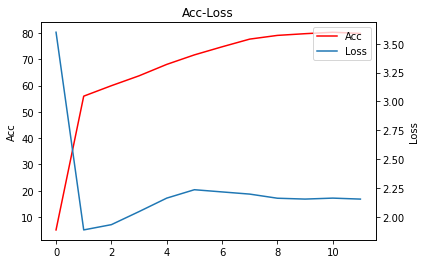

In [327]:
x = np.arange(len(S.loss_acc))
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc = ax1.plot(x,S_acc,'r',label='Acc')
ax1.set_ylabel('Acc')
ax1.set_title('Acc-Loss')

ax2 = ax1.twinx()
loss = ax2.plot(x,S_loss,label='Loss')
ax2.set_ylabel('Loss')

lns = acc+loss
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs)
plt.show()

In [226]:
NodeList

[[2, 4, 1, 6, 5, 7, 8],
 [2, 0, 5, 6, 8, 1, 4],
 [8, 0, 2, 7, 5, 4, 1],
 [7, 8, 2, 6, 1, 5, 3],
 [0, 5, 2, 1, 8, 7, 6],
 [7, 5, 8, 6, 3, 1, 2],
 [8, 7, 0, 5, 2, 6, 1],
 [6, 1, 3, 8, 7, 5, 0],
 [5, 7, 8, 0, 6, 3, 2],
 [8, 5, 6, 1, 7, 2, 3]]

In [328]:
img = np.ones(shape=(10,len(S.loss_acc)),dtype=int)

In [329]:
for i in range(len(NodeList)):
  for j in NodeList[i]:
    img[i][j]=0

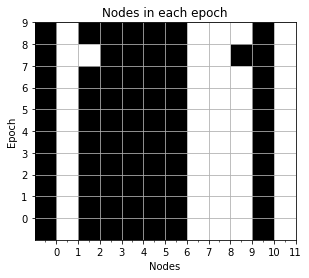

In [331]:
len_n = len(S.loss_acc)
ax = plt.gca()
ax.set_xlim(-0.5,len_n-0.5)
ax.set_ylim(-0.5,9.5)
miloc = plt.MultipleLocator(1)
ax.xaxis.set_minor_locator(miloc)
plt.grid()
plt.title("Nodes in each epoch")
plt.imshow(img*255,cmap='gray')
plt.axis('on')
plt.xlabel('Nodes')
plt.ylabel('Epoch')
x = np.arange(0.5,len_n+0.5,1)
y = np.arange(0.5,10.5,1)
plt.xticks()
plt.yticks(y,(int(i-0.5) for i in y))
plt.xticks(x,(int(i-0.5) for i in x))
plt.show()

设置对照组，即普通的FedAvg

In [305]:
def FedAvg_Baseline(NUM_CLIENTS,model):
  iterModel = model.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')
    for node in range(NUM_CLIENTS):
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp/NUM_CLIENTS)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return iterModel

In [332]:
InitModel = FLModel(row=28,col=28,num_classes=36)
S2 = ParamServer("")
S2.PreEval(InitModel,x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 3.5249 - accuracy: 0.0622


In [333]:
SendModel = S2.PreTrain(InitModel,x_train[0:200],y_train[0:200],epochs=1)
S2.PreEval(SendModel,x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.9525 - accuracy: 0.5709


In [291]:
NUM_EPOCHS = 10

In [334]:
for e in range(NUM_EPOCHS):
  print("EPOCHS {} is starting...".format(e))
  for i in range(NUM_CLIENTS):
    clients[i].ReceiveModel(SendModel.copy())
    clients[i].NodeTrain()
    # clients[i].NodeEval()
    # DIS.append(Distance(SendModel,clients[i].model))
  FedModel = FedAvg_Baseline(NUM_CLIENTS,SendModel)
  S2.PreEval(FedModel,x_test,y_test)
  SendModel = FedModel.copy()

EPOCHS 0 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.1722 - accuracy: 0.8481
EPOCHS 1 is starting...
313/313 [==============================] - 1s 3ms/step - loss: 2.3527 - accuracy: 0.8789
EPOCHS 2 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.3203 - accuracy: 0.8829
EPOCHS 3 is starting...
313/313 [==============================] - 1s 3ms/step - loss: 2.2192 - accuracy: 0.8902
EPOCHS 4 is starting...
313/313 [==============================] - 1s 3ms/step - loss: 2.1297 - accuracy: 0.8936
EPOCHS 5 is starting...
313/313 [==============================] - 1s 3ms/step - loss: 2.0409 - accuracy: 0.8989
EPOCHS 6 is starting...
313/313 [==============================] - 1s 3ms/step - loss: 1.9284 - accuracy: 0.8875
EPOCHS 7 is starting...
313/313 [==============================] - 1s 3ms/step - loss: 1.8723 - accuracy: 0.8940
EPOCHS 8 is starting...
313/313 [==============================] - 1s 3ms/step - loss: 1.8051 - 

In [335]:
S_acc =[S2.loss_acc[i][1]*100 for i in range(len(S2.loss_acc))]
S_loss =[S2.loss_acc[i][0] for i in range(len(S2.loss_acc))]

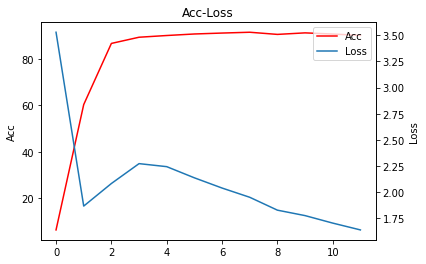

In [336]:
x = np.arange(len(S2.loss_acc))
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc = ax1.plot(x,S_acc,'r',label='Acc')
ax1.set_ylabel('Acc')
ax1.set_title('Acc-Loss')

ax2 = ax1.twinx()
loss = ax2.plot(x,S_loss,label='Loss')
ax2.set_ylabel('Loss')

lns = acc+loss
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs)
plt.show()

## 节点训练
OK！fine,我这两天就是为了实现一个循环。。。
真他娘的丢人

In [ ]:
for i in range(NUM_CLIENTS):
  clients[i].ReceiveModel(a.copy())
  clients[i].NodeTrain()

In [ ]:
for i in range(NUM_CLIENTS):
  print("Node {} is evaluating...".format(i))
  clients[i].NodeEval()
  ##虽然这个步骤没啥用

Node 0 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.3676 - accuracy: 0.9269
Node 1 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.3695 - accuracy: 0.9273
Node 2 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.5132 - accuracy: 0.9271
Node 3 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.3902 - accuracy: 0.9242
Node 4 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.4435 - accuracy: 0.9231
Node 5 is evaluating...
313/313 [==============================] - 1s 1ms/step - loss: 0.3814 - accuracy: 0.9300
Node 6 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.3722 - accuracy: 0.9262
Node 7 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.3679 - accuracy: 0.9250
Node 8 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.4051 - 

In [ ]:
def DiffModel(model1,model2,layer_name,w_vs_b=0):
  l1 = model1.get_layer(layer_name).get_weights()[w_vs_b].reshape([-1,])
  l2 = model2.get_layer(layer_name).get_weights()[w_vs_b].reshape([-1,])
  # l1 = model1.trainable_variables
  # l2 = model2.trainable_variables
  # print(l1)
  l1.shape
  # l1 = l1.reshape([-1,])
  # l2 = l2.reshape([-1,])
  for i in range(len(l1)):
    if l1[i]!=l2[i]:
      print("NOT SAME MODEL")
      return

In [ ]:
DiffModel(clients[0].model,clients[1].model,'dense_1')

NOT SAME MODEL


## 模型聚合 FedAvg
THIS IS THE MOST IMPORANT！

In [ ]:
##先实现普通聚合，再考虑距离问题

In [ ]:
# clients[0].Train_dataset[0].shape

(60000, 28, 28)

In [ ]:
# a_1 = a.trainable_variables
# b_1 = clients[0].model.trainable_variables
# for _a,_b in zip(a_1,b_1):
#   # print(_a,_b,'\n')
#   print(type(_a))

<class 'tensorflow.python.eager.def_function.UnliftedInitializerVariable'>
<class 'tensorflow.python.eager.def_function.UnliftedInitializerVariable'>
<class 'tensorflow.python.eager.def_function.UnliftedInitializerVariable'>
<class 'tensorflow.python.eager.def_function.UnliftedInitializerVariable'>


In [ ]:
# tmp = a_1[0]
# tmp2 = b_1[0]

In [ ]:
# print(tmp.name)
# print(tmp2.name)

fl_model_57/dense_1/kernel:0
fl_model_60/dense_1/kernel:0


In [ ]:
# tmp.numpy()

array([[-0.07970653,  0.07991762,  0.05910995, ...,  0.0579403 ,
         0.0321511 ,  0.02421231],
       [-0.05695383,  0.03625515, -0.06860252, ...,  0.02591816,
         0.04554088,  0.02055327],
       [-0.01783558, -0.04462572, -0.02057564, ...,  0.02187481,
        -0.04054561, -0.02853347],
       ...,
       [-0.05783828, -0.05880497,  0.07976013, ..., -0.03510847,
        -0.03695404,  0.03616227],
       [-0.06651882,  0.02818294, -0.02726433, ..., -0.05769905,
        -0.04426115, -0.00901749],
       [-0.01624558,  0.05673347, -0.07569796, ..., -0.05263541,
        -0.0753431 , -0.04903179]], dtype=float32)

In [ ]:
# tmp.numpy().shape

(784, 128)

In [ ]:
#  tmp2 =np.zeros(a.trainable_variables[0].numpy().shape,dtype='float64')

In [ ]:
# tmp2.shape

(784, 128)

In [ ]:
#聚合先不考虑权重
def FedAvg(NUM_CLIENTS):
  iterModel = a.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')

    for node in range(NUM_CLIENTS):
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return iterModel

In [ ]:
fedmodel = FedAvg(10)

In [ ]:
#昨天留的任务是如何把聚合后的numpy数组，转到模型中

In [ ]:
S.PreEval(fedmodel,x_test,y_test)

313/313 [==============================] - 1s 1ms/step - loss: 7.8235 - accuracy: 0.2031


In [ ]:
len(fed)

4

In [ ]:
img = np.array(np.random.randint(2,size=(10,10))*255)

In [ ]:
img

array([[255, 255, 255,   0,   0, 255,   0,   0, 255, 255],
       [  0, 255, 255, 255, 255, 255, 255,   0,   0,   0],
       [255, 255, 255, 255,   0,   0, 255, 255,   0, 255],
       [  0, 255, 255, 255, 255,   0, 255, 255,   0, 255],
       [255, 255,   0, 255,   0, 255,   0,   0, 255,   0],
       [  0,   0,   0, 255, 255, 255,   0, 255,   0, 255],
       [  0, 255, 255,   0, 255, 255, 255,   0,   0, 255],
       [  0, 255, 255,   0,   0, 255, 255, 255, 255,   0],
       [255,   0,   0,   0,   0,   0,   0,   0, 255, 255],
       [255, 255, 255,   0,   0, 255, 255,   0, 255, 255]])

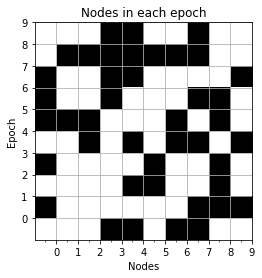

In [99]:
ax = plt.gca()
ax.set_xlim(-0.5,9.5)
ax.set_ylim(-0.5,9.5)
miloc = plt.MultipleLocator(1)
ax.xaxis.set_minor_locator(miloc)
plt.grid()
plt.title("Nodes in each epoch")
plt.imshow(img,cmap='gray')
plt.axis('on')
plt.xlabel('Nodes')
plt.ylabel('Epoch')
x = np.arange(0.5,10.5,1)
y = np.arange(0.5,10.5,1)
plt.xticks()
plt.yticks(y,(int(i-0.5) for i in y))
plt.xticks(x,(int(i-0.5) for i in x))
plt.show()

In [105]:
img2 = np.array([random.random() for x in range(10)])

In [106]:
img2

array([0.62784529, 0.28131526, 0.01260447, 0.43294956, 0.66724747,
       0.61818811, 0.37726141, 0.77486108, 0.34165029, 0.03846563])

In [108]:
x = np.arange(10)

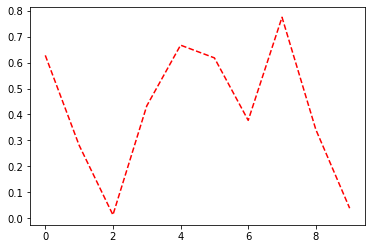

In [110]:
l1 = plt.plot(x,img2,'r--',label='type1')